# Défi IA

Alexia Grenouillat - Arthur Boivert - Hugo Lelièvre

On charge tout d'abord les bibliothèques dont nous auront besoin pour la suite.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv


## I - Analyse des données obtenues avec les requêtes

Nos données sont contenues dans le fichier "pricing_requests.csv" que nous avons fabriqué grâce au notebook "Requetes défi IA".

In [21]:
pricing_requests = pd.read_csv("pricing_requests.csv")
pricing_requests.head()

,hotel_id,price,stock,city,date,language,mobile,avatar_id,request_order,avatar_nb_requests
0,300,145,1,copenhagen,2,hungarian,0,28434,1.0,1.0
1,855,311,1,copenhagen,2,hungarian,0,28434,1.0,1.0
2,757,151,1,copenhagen,2,hungarian,0,28434,1.0,1.0
3,805,202,2,copenhagen,2,hungarian,0,28434,1.0,1.0
4,930,120,0,copenhagen,2,hungarian,0,28434,1.0,1.0


### Utilisation du jeu de données "features_hotels.csv"

Le nombre d'hôtels étant très grand, nous avons d'abord cherché à utiliser les informations à disposition sur les hôtels, afin de les regrouper plus facilement. 

In [25]:
features_hotels = pd.read_csv("features_hotels.csv")
df_train_1 = pricing_requests.merge(features_hotels, on = ["hotel_id","city"])

La variable groupe est entièrement déterminée par la variable brand. Dans un même groupe, il peut y avoir des grandes différences de prix entre les marques, on a donc décidé de ne garder que la variable brand.

<AxesSubplot: xlabel='price', ylabel='brand'>

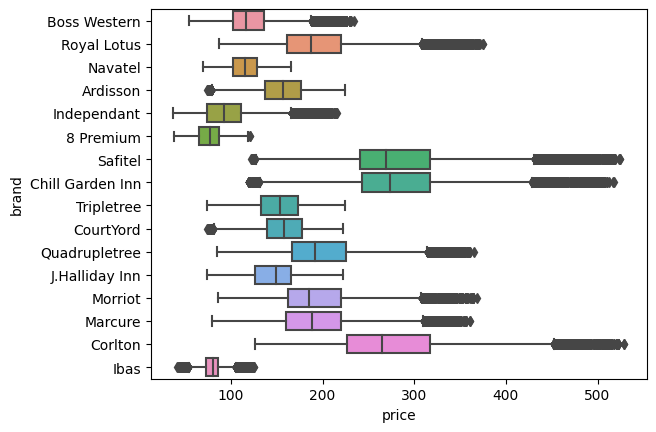

In [41]:
sns.boxplot(data=df_train_1, x="price", y="brand")

Nous avons étudié (comme ci-dessus) les différentes variables pour regarder leur influence sur le prix. Celles qui ressortent le plus sont les variables brand, pool, date, stock et city. Il y en a d'autres qui ont aussi un effet, mais il est plus minime. Nous avons alors essayé d'entraîner un modèle en gardant uniquement ces variables là.

Nous transformons les variables qualitatives en variables binaire avec un one-hot encoding.

In [46]:
df_dummies_1 = pd.get_dummies(data=df_train_1.loc[:,["price","brand","pool","date","stock","city"]], columns = ['brand','city'], drop_first=True)
data_train, data_test = train_test_split(df_dummies_1,test_size=0.25,random_state=1)
X_train = data_train.loc[:,data_train.columns != "price"]
Y_train = data_train.loc[:,"price"]
X_test = data_test.loc[:,data_train.columns != "price"]
Y_test = data_test.loc[:,"price"]

In [48]:
lr = LinearRegression().fit(X_train, Y_train)
y_pred_rf = lr.predict(X_test)
MSE_rf = np.mean((Y_test-y_pred_rf)**2)
print(MSE_rf)
df_importance = pd.DataFrame({'var':X_train.columns,"imp":lr.coef_}).sort_values('imp',ascending=False)
# df_importance

791.0674326624127


Le résultat est très mauvais avec un modèle linéaire, on va utiliser une random forest à la place.

In [57]:
rf = RandomForestRegressor().fit(X_train, Y_train)
df_importance = pd.DataFrame({'variable':X_train.columns,"importance":rf.feature_importances_}).sort_values('importance',ascending=False)
y_pred_rf = rf.predict(X_test)
MSE_rf = np.mean((Y_test-y_pred_rf)**2)
print(MSE_rf)

145.38715096207457


Pour avoir de meilleurs résultats, nous avons modifié les prix pour que toutes les valeurs de la variable price soient entre 0 et 1.

In [52]:
def ScaleList(list):
    xmin = min(list) 
    xmax=max(list)
    for i, x in enumerate(list):
        list[i] = (x-xmin) / (xmax-xmin)

Nous avons également essayé d'appliquer un logarithme aux prix pour améliorer les prédictions, mais le résultat n'était pas meilleur. 

Nous avons alors décidé de ne plus utiliser les meta variables, mais de travailler hôtel par hôtel. Toutes les informations du fichier "features_hotels.csv" sont contenues dans la variable hotel_id. Nous utiliserons donc cette dernière.

### Comment gérer la variable hotel_id ?

#### One-hot encoding

Notre première approche a été la plus basique : créer une variable binaire pour chaque hôtel. Les résultats ont été meilleurs que ceux obtenus précédemment. Cependant, les algorithmes étaient extrêmement longs à converger (plusieurs heures), et cette solution n'était donc pas viable.

#### Utilisation de fonctions carré

En analysant l'impact des variables sur les prédictions, les variables qui semblaient les plus importantes étaient hotel_id et date. Nous avons donc affiché l'évolution du prix hôtel par hôtel en fonction de la date.

<AxesSubplot: xlabel='date', ylabel='price'>

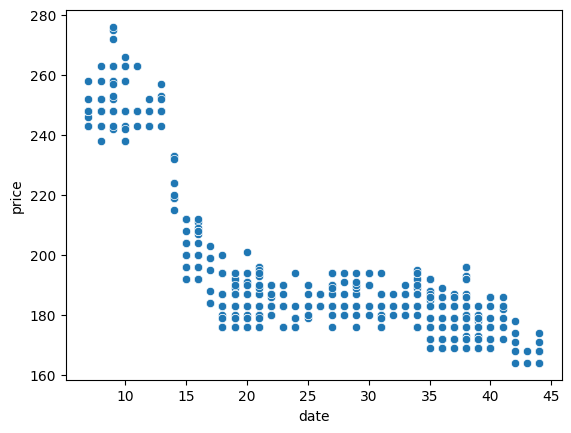

In [216]:
df_0 = pricing_requests.loc[pricing_requests.hotel_id==0]

sns.scatterplot(data=df_0, x="date", y="price")

Les prix donnent l'impression de suivre un polynôme de degré 2 en la variable date, avec un bruit additionnel. On a donc décidé de fit un polynôme de degré 2 pour chaque hôtel, et de s'en servir pour faire les prédictions.

In [214]:
def SubmissionDegree2(train, test):
    res = []
    for k in test.index:
        df_k = train[(train.hotel_id == test.loc[k,"hotel_id"])&(train.request_number==1)]
        a,b,c = np.polyfit(df_k.date, df_k.price, deg = 2)
        x = test.loc[k,"date"]
        f_x = c + b*x + a*(x**2)
        min_k, max_k = min(df_k.price), max(df_k.price)
        if f_x > max_k:
            f_x = max_k
        if f_x < min_k:
            f_x = min_k
        res.append(f_x)
    return pd.DataFrame({"index":test.index,"price":res})

Ce code n'est pas optimisé puisqu'on recalcule le polynôme à chaque nouvelle ligne du jeu de test. Cependant, comme ce jeu de données est relativement petit, le code tournait presque instantanément et nous n'avons pas cherché à l'optimiser.

Avec ce modèle, nous obtenions un score autour de 35, ce qui n'est pas mauvais, mais pas non plus transcendant.

#### Target encoding

Nous avons ensuite cherché à remplacer la variable hotel_id par une autre variable plus simple à exploiter pour les algorithmes. Nous avons eu l'idée de calculer les moyennes des prix pour chaque hôtel, et d'utiliser cette variable à la place.

In [65]:
hotel_price = pricing_requests.groupby('hotel_id').price.mean()
df_train_2 = pricing_requests.merge(hotel_price, on='hotel_id', how='left', suffixes=("", "_mean"))
df_dummies_2 = pd.get_dummies(data=df_train_2.loc[:,["price","price_mean","language","date","stock","city"]], columns = ['language','city'], drop_first=True)

data_train, data_test = train_test_split(df_dummies_2,test_size=0.25,random_state=1)
X_train = data_train.loc[:,data_train.columns != "price"]
Y_train = data_train.loc[:,"price"]
X_test = data_test.loc[:,data_train.columns != "price"]
Y_test = data_test.loc[:,"price"]

In [66]:
rf = RandomForestRegressor().fit(X_train, Y_train)
df_importance = pd.DataFrame({'variable':X_train.columns,"importance":rf.feature_importances_}).sort_values('importance',ascending=False)
y_pred_rf = rf.predict(X_test)
MSE_rf = np.mean((Y_test-y_pred_rf)**2)
print(MSE_rf)

9.397245870982461


On obtient des résultats qui sont bien meilleurs qu'avant. Cependant, lors des soumissions les scores ne sont toujours pas terribles (en tout cas, bien supérieurs à 9). Si nous arrivons plutôt bien à prédire nos données, mais pas les données de test, c'est qu'il y a une différence entre les 2 jeux de données.

## II - Comparaison de nos données d'entraînement aux données de test : adversarial validation

On va à présent créer un modèle de classification binaire afin de voir si les 2 jeux de données sont distinguables facilement.

In [70]:
test_sample = pd.read_csv("test_set.csv").drop(["index","order_requests"], axis=1)
train = pricing_requests.loc[pricing_requests.avatar_nb_requests < 5,:]

Chaque avatar du jeu de test a fait maximum 4 requêtes, on filtre donc nos données pour correspondre au mieux au jeu de test.

La fonction suivante permet d'ajouter au jeu de test la colonne avatar_nb_request qui permet de numéroter les requêtes de chaque avatar afin d'essayer de capter un lien entre le nombre de requêtes effectuées et l'augmentation des prix.

In [69]:
def AddRequestOrder(df, request_order = 1):
    data = df.copy()
    data["request_order"] = np.nan
    data["avatar_nb_requests"] = np.nan
    avatar_id = data.loc[0,"avatar_id"]
    date = data.loc[0,"date"]
    city = data.loc[0,"city"]
    language = data.loc[0,"language"]
    mobile = data.loc[0,"mobile"]
    avatar_nb_requests = 1
    for k in range(len(data)):
        if data.loc[k,"avatar_id"] != avatar_id :
            avatar_id = data.loc[k,"avatar_id"]
            date = data.loc[k,"date"]
            city = data.loc[k,"city"]
            language = data.loc[k,"language"]
            mobile = data.loc[k,"mobile"]
            avatar_nb_requests = 1
            request_order += 1
        elif data.loc[k,"date"] != date or data.loc[k,"city"] != city or data.loc[k,"language"] != language or data.loc[k,"mobile"] != mobile:
            date = data.loc[k,"date"]
            city = data.loc[k,"city"]
            language = data.loc[k,"language"]
            mobile = data.loc[k,"mobile"]
            avatar_nb_requests += 1
            request_order += 1
        data.loc[k,"request_order"] = request_order
        data.loc[k,"avatar_nb_requests"] = avatar_nb_requests
    return data

In [71]:
test = AddRequestOrder(test_sample)

# On garde uniquement les variables numériques dans un premier temps
X_test  = test.select_dtypes(include=['number']).copy()
X_train = train.select_dtypes(include=['number']).copy()

X_train = X_train.drop(['price'], axis=1)

# on ajoute les labels correspondants
X_train["AV_label"] = 0
X_test["AV_label"]  = 1

# On regroupe les 2 DF
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# On melange les lignes entre elles
all_data_shuffled = all_data.sample(frac=1)

# On cree notre matrice pour XGBoost 
X = all_data_shuffled.drop(['AV_label'], axis=1)
X = X.drop(['avatar_id','request_order','hotel_id'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X,label=y)

# our XGBoost parameters
params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

In [72]:
# perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

199    0.827399
Name: test-auc-mean, dtype: float64


On obtient un AUC de 0.82. Le classifieur binaire est capable de plutôt bien déterminer à quel jeu de donnée appartient une ligne, alors qu'il n'utilise même pas les variables language et city.

c:\Users\Hugo\anaconda3\envs\AIF\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


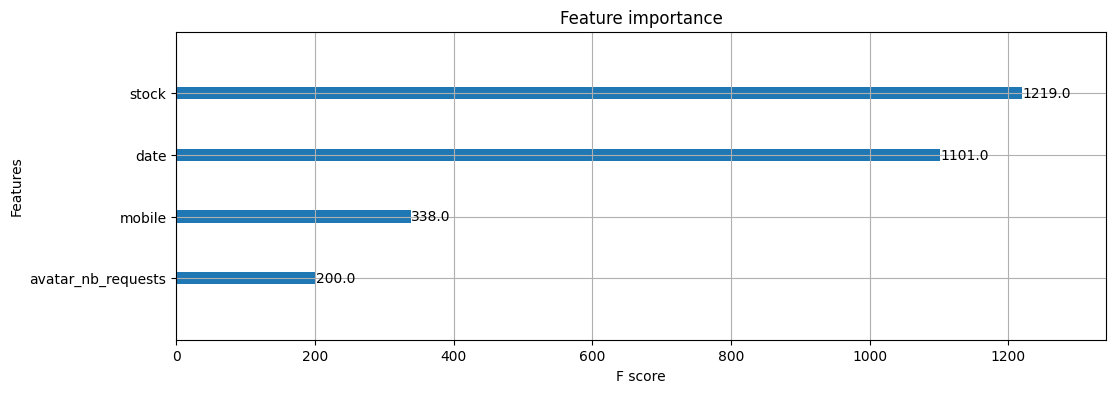

In [74]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show()

Les variables stock et date permettent au classifieur de déterminer à quel DF appartient une ligne, c'est donc sûrement que nos distributions des dates et du stock ne sont pas les mêmes que celles du jeu de test.

C:\Users\Hugo\AppData\Local\Temp\ipykernel_5108\2881123250.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


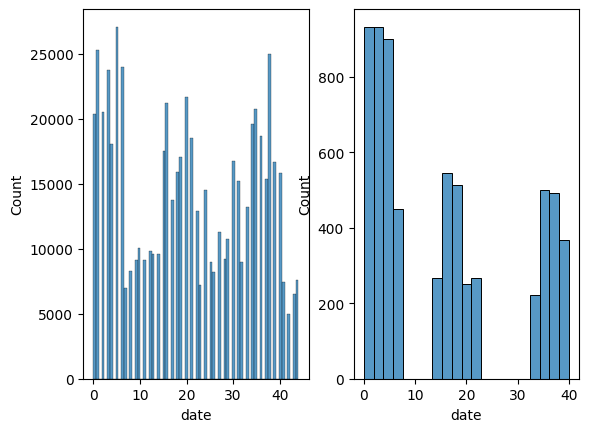

In [82]:
fig, ax =plt.subplots(1,2)
sns.histplot(data=pricing_requests,x="date", ax=ax[0])
sns.histplot(data=test,x="date", ax=ax[1])
fig.show()


Les dates du jeu de test sont regroupées dans 3 plages séparées et ne sont pas du tout choisies aléatoirement comme nous l'avions imaginé. Il est donc logique que la classifieur utilise cette variable pour discriminer les jeux de données.

Le graphique de gauche est faussé car il est effectué avec la totalité de nos données et pas uniquement sur celles que nous avions à ce moment là.

In [93]:
max(classifier.predict(all_data_shuffled[X.columns]))

0

Quand on regarde de plus près le classifieur, on se rend compte qu'il prédit 0 tout le temps. Cela vient sûrement du fait que les 2 jeux de données sont très déséquilibrés : il y a beaucoup plus de données d'entrainement que de test. Pour remedier à ça nous avons imaginé une solution : 

Boucle :

$\rightarrow$ choisir autant de lignes du train set qu'il y a de lignes dans le test set

$\rightarrow$ fit un classifieur binaire avec ces données

$\rightarrow$ utiliser ce classifieur pour prédire les données restantes

Fin


Pour chaque ligne du train set on compte alors le nombre de fois qu'elle a été classée comme étant dans le test. Plus une ligne a été souvent classée comme appartenant au test set, plus elle a de chance d'y ressembler. On va alors selectionner les lignes qui ont été classées souvent comme appartenant au test set et les garder pour la suite.

In [147]:
def ApplyBinClass(df_train, df_test):
    train = df_train.copy().sample(frac=1).reset_index(drop=True)
    test = df_test.copy().sample(frac=1).reset_index(drop=True)
    price = train.price
    train = train.drop("price", axis=1)
    train['nb_class_test'] = 0
    train["AV_label"] = 0
    test["AV_label"]  = 1
    k = 0
    n = len(test)
    while k + n < len(train):
        X_train = train.loc[k:k+n,train.columns != "nb_class_test"]
        all_data = pd.concat([X_train, test[X_train.columns]], axis=0, ignore_index=True)
        all_data_shuffled = all_data.sample(frac=1)
        X = all_data_shuffled.drop(['AV_label'], axis=1).select_dtypes(include=['number'])
        X = X.drop(['avatar_id','request_order'], axis=1)
        y = all_data_shuffled['AV_label']
        classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
        classifier.fit(X, y)
        fig, ax = plt.subplots(figsize=(12,4))
        plot_importance(classifier, ax=ax)
        plt.show()
        prediction_test = classifier.predict(train[X.columns])
        train['nb_class_test'] += prediction_test
        k += n
    train["price"] = price
    return train.drop("AV_label", axis=1)

In [ ]:
df_bin_class = ApplyBinClass(train, test)

(array([493951.,  13653.,  10499.,   7932.,   7333.,   6011.,   7091.,
          5019.,   6310.,  10302.]),
 array([ 0. ,  8.5, 17. , 25.5, 34. , 42.5, 51. , 59.5, 68. , 76.5, 85. ]),
 <BarContainer object of 10 artists>)

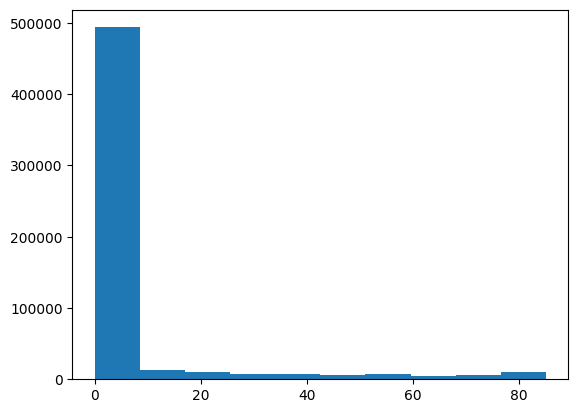

In [149]:
plt.hist(df_bin_class.nb_class_test)

Gardons uniquement les lignes qui ont été classées comme appartenant au test set au moins 30 fois. Normalement elles devraient beaucoup y ressembler.

In [164]:
df_train_3 = df_bin_class[df_bin_class.nb_class_test > 30]

(array([10015.,  6434.,     0.,  2361.,  8829.,  4562.,     0.,     0.,
         3719.,  8921.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

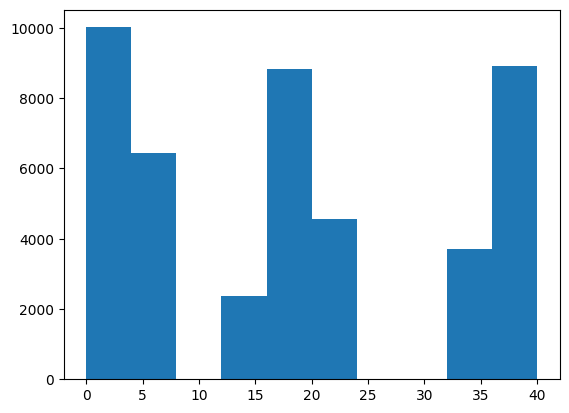

In [153]:
plt.hist(df_train_3.date)

Cette fois-ci, les dates des lignes d'entrainement gardées semblent avoir la même distribution que celles du test set.

In [165]:
hotel_price = df_train_3.groupby('hotel_id').price.mean()
df_train_3 = df_train_3.merge(hotel_price, on='hotel_id', how='left', suffixes=("", "_mean"))
# hotel_date = df_train_3.groupby('hotel_id').date.mean()
# df_train_3 = df_train_3.merge(hotel_date, on='hotel_id', how='left', suffixes=("", "_mean"))
df_dummies_3 = pd.get_dummies(data=df_train_3.loc[:,["price","price_mean","date_mean","language","date","stock","city"]], columns = ['language','city'], drop_first=True)

data_train, data_test = train_test_split(df_dummies_3,test_size=0.25,random_state=1)
X_train = data_train.loc[:,data_train.columns != "price"]
Y_train = data_train.loc[:,"price"]
X_test = data_test.loc[:,data_train.columns != "price"]
Y_test = data_test.loc[:,"price"]

In [166]:
rf = RandomForestRegressor().fit(X_train, Y_train)
df_importance = pd.DataFrame({'variable':X_train.columns,"importance":rf.feature_importances_}).sort_values('importance',ascending=False)
y_pred_rf = rf.predict(X_test)
MSE_rf = np.mean((Y_test-y_pred_rf)**2)
print(MSE_rf)

9.649830398852604


Les résultats étant encourageants, nous avons décidé de changer notre manière de requêter afin que nos données ressemblent au jeu de test. Pour cela, nous avons essayé de reproduire la même distribution de date, de mobile et de la paire language-city au cas où ces 2 variables étaient liées. 

Pour cela, nous avons stocké dans une liste toutes les paires language-city du test set (en conservant les doublons, donc autant de paires que de lignes dans le test set). Pour chaque requête, nous avons tiré aléatoirement dans cette liste pour choisir le langage et la ville de la requête. Ainsi, les combinaisons n'existant pas dans le jeu de test ne sont pas dans nos nouvelles données, et les paires les plus présentes dans le test set le sont aussi dans nos données.

Pour la variable mobile, nous avons calculé la proportion de 1 dans le test set et avons simulé des loi de bernouilli de paramètre cette proportion.

Enfin, pour la variable date, nous avons stocké dans une grande liste les dates de chaque avatar. Certains ne faisaient qu'une seule requêtes, mais d'autres en faisaient plusieurs. En faisant cela, on réalisait des requêtes à des successions de dates présentes dans le test set afin d'augmenter notre ressemblance.

(Les codes sont dans le notebook sur les requêtes)

## Analyse plus détaillée des variables

### Lien entre language et city

En regardant les features_importances_ de nos random forests, on avait l'impression que la variable language avait un effet très négligeable. Cependant, en regardant quelques lignes plus en détail on avait l'impression que les prix étaient plus faible lorsqu'un avatar faisait une requête dans son pays. C'est à dire quand language et city correspondent au même pays. Exemple : city = "paris" et language = "french".

Pour vérifier cet effet, nous avons alors créé les fonctions suivantes :

In [ ]:
def TestSameCountry(city, language):
    if city == "amsterdam" and language == "dutch":
        return True
    if city == "copenhagen" and language == "danish":
        return True
    if city == "madrid" and language == "spanish":
        return True
    if city == "paris" and language == "french":
        return True
    if city == "rome" and language == "italian":
        return True
    if city == "sofia" and language == "bulgarian":
        return True
    if city == "valleta" and language == "maltese":
        return True
    if city == "vienna" and language == 'austrian':
        return True
    if city == "vilnius" and language == "lithuanian":
        return True
    else:
        return False

def SameCountry(db):
    data = db.copy()
    data["same_country"] = 0
    for k in range(len(data)):
        if TestSameCountry(data.loc[k,"city"], data.loc[k,"language"]):
            data.loc[k,"same_country"] = 1
    return data

Malheureusement, nous n'avons rien pu conclure de très intéressant grâce à elles.

### Déterminer l'impact de chaque variable

Afin de déterminer plus précisément l'impact de chaque variable, nous avons décidé de faire touner un modèle linéaire sur chaque hôtel séparément. Les modèles linéaires sont moins performants que des forêts aléatoires, mais ils ont l'avantage de pouvoir donner les coefficients en sortie, et donc de pouvoir interpréter chaque variable.

En particulier, on peut étudier chaque modalité de la variable language. En utilisant du one-hot encoding, ces coefficients correspondent directement au prix qu'il faut rajouter/ enlever à la prédiction en fonction du langage.

Pour avoir des coefficients robustes, nous avons fait tourner un modèle linéaire pour chaque hôtel, gardé uniquement ceux avec un MSE < 20 pour ne pas avoir de modèle trop mauvais. Pour chaque variable, nous avons ensuite effectué une moyenne de leur coefficients pour estimer leur impact global.

In [218]:
def CalcImpactVariables(pricing_requests):
    nb_models = 0
    for k, hotel_id in enumerate(np.sort(pricing_requests.loc[~pricing_requests.hotel_id.isin(test_sample.hotel_id.unique()),:].hotel_id.unique())):
        df_hotel_k = pricing_requests.loc[(pricing_requests.hotel_id==hotel_id) & (pricing_requests.avatar_nb_requests<4),:]
        bdd_dummies = pd.get_dummies(data=df_hotel_k.drop(["hotel_id","city","avatar_id","request_order"], axis=1), columns = ['language'], drop_first=True)
        X_train = bdd_dummies.loc[:,bdd_dummies.columns != "price"]
        Y_train = bdd_dummies.loc[:,"price"]
        lr = LinearRegression().fit(X_train, Y_train)
        y_pred_lr = lr.predict(X_train)
        MSE_lr = np.mean((Y_train-y_pred_lr)**2)
        if MSE_lr < 20 :
            if nb_models == 0:
                list_var = [x for x in X_train.columns]
                list_importance = lr.coef_
                nb_models = 1
            else : 
                list_var_temp = [x for x in X_train.columns]
                list_importance_temp = lr.coef_
                for k, variable in enumerate(list_var):
                    my_ind = list_var_temp.index(variable)
                    list_importance[k] += list_importance_temp[my_ind]
            nb_models += 1
    df_importance = pd.DataFrame({'variables':list_var,"importances":list_importance/nb_models})
    return df_importance

def GetCoeffLR(df, variable):
    return df.loc[df.variables==variable,"importances"].values[0]

def AjusterPrixLangage(df, df_impact_variables, list_prices):
    list_prix = np.copy(list_prices)
    for i, k in enumerate(df.index):
        if df.loc[k,"language"] != "austrian":
            alpha_3 = GetCoeffLR(df_impact_variables, 'language_' + df.loc[k,"language"])
        else: alpha_3 = 0
        print(list_prix[i], list_prix[i] + alpha_3)
        list_prix[i] += alpha_3
    return list_prix

In [223]:
impact_variables = CalcImpactVariables(pricing_requests)
impact_variables.sort_values("importances", ascending=False)

,variables,importances
12,language_finnish,2.217274
29,language_swedish,1.346836
9,language_danish,0.376142
3,avatar_nb_requests,0.087427
1,date,-0.014112
0,stock,-0.155664
2,mobile,-0.221342
7,language_cypriot,-0.369406
24,language_portuguese,-1.289378
17,language_irish,-2.052548


On remarque quelque chose d'important : en changeant de langage on peut avoir un prix qui varie d'une dizaine d'euros.

Nous avons alors essayé de supprimer la variable language de nos modèles. Nous avons effectué nos prédictions normalement, puis nous avons ajouté/soustrait aux predictions le prix correspondant à chaque langage. 

Les résultats étaient légèrement meilleurs, mais nous ne sommes pas parvenus à descendre en dessous de 26 de score.